In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
from pandas import Series,DataFrame
from scipy.stats import norm, skew, kurtosis, shapiro
from statsmodels.tsa.stattools import adfuller

In [84]:


# Define pairs
pairs = ["BTC-USD", "ETH-USD", "DOGE-USD", "XMR-USD", "LTC-USD", "XRP-USD", "XEM-USD", "XLM-USD", "USDT-USD", "DASH-USD"]

# Download data for each pair
for pair in pairs:
    data = yf.download(pair, start="2017-11-09", end=pd.to_datetime('today'))
    data = data[['Close', 'Volume']]
    data.to_csv(pair.replace("-", "") + "_prices.csv")




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [85]:



pairs = ["BTCUSD", "ETHUSD", "DOGEUSD", "XMRUSD", "LTCUSD", "XRPUSD", "XEMUSD", "XLMUSD", "USDTUSD", "DASHUSD"]


returns_df = pd.DataFrame()

for pair in pairs:

    filename = f"{pair}_prices.csv"
    pair_df = pd.read_csv(filename)

    pair_df[f'{pair}'] = np.log(pair_df['Close'] / pair_df['Close'].shift(1))

    if returns_df.empty:
        returns_df = pair_df[[f'{pair}']]

    else:
        returns_df = pd.concat([returns_df, pair_df[f'{pair}']], axis=1)


returns_df = returns_df.dropna()

In [86]:
returns_df

,BTCUSD,ETHUSD,DOGEUSD,XMRUSD,LTCUSD,XRPUSD,XEMUSD,XLMUSD,USDTUSD,DASHUSD
1,-0.076400,-0.069790,-0.196127,-0.134445,-0.081152,-0.051926,-0.135645,-0.188811,-0.002155,0.010870
2,-0.040163,0.050270,0.032152,0.124761,0.050078,0.018935,-0.002465,-0.000605,0.002958,0.048809
3,-0.066248,-0.021758,-0.145859,0.034833,-0.054385,-0.064230,-0.064512,-0.159429,0.003443,0.437750
4,0.097510,0.028204,0.154151,-0.003672,0.039724,0.030458,0.065727,0.084145,-0.003086,-0.226693
5,0.011559,0.063948,-0.022548,-0.008537,0.020683,0.030893,0.009335,0.171026,-0.002500,0.000393
...,...,...,...,...,...,...,...,...,...,...
2489,0.030697,0.044422,0.038685,0.005209,0.027675,0.035137,0.060538,0.025676,-0.000111,0.048845
2490,-0.028857,-0.047433,-0.024471,0.013769,-0.013664,-0.018127,-0.057162,-0.009997,-0.000144,0.013286
2491,0.009368,0.011653,0.013413,-0.011779,0.015475,0.001407,0.020020,0.002239,0.000268,-0.005962
2492,-0.031739,-0.033736,0.002893,0.009475,0.009965,-0.025365,-0.020878,-0.015378,-0.000265,-0.003250


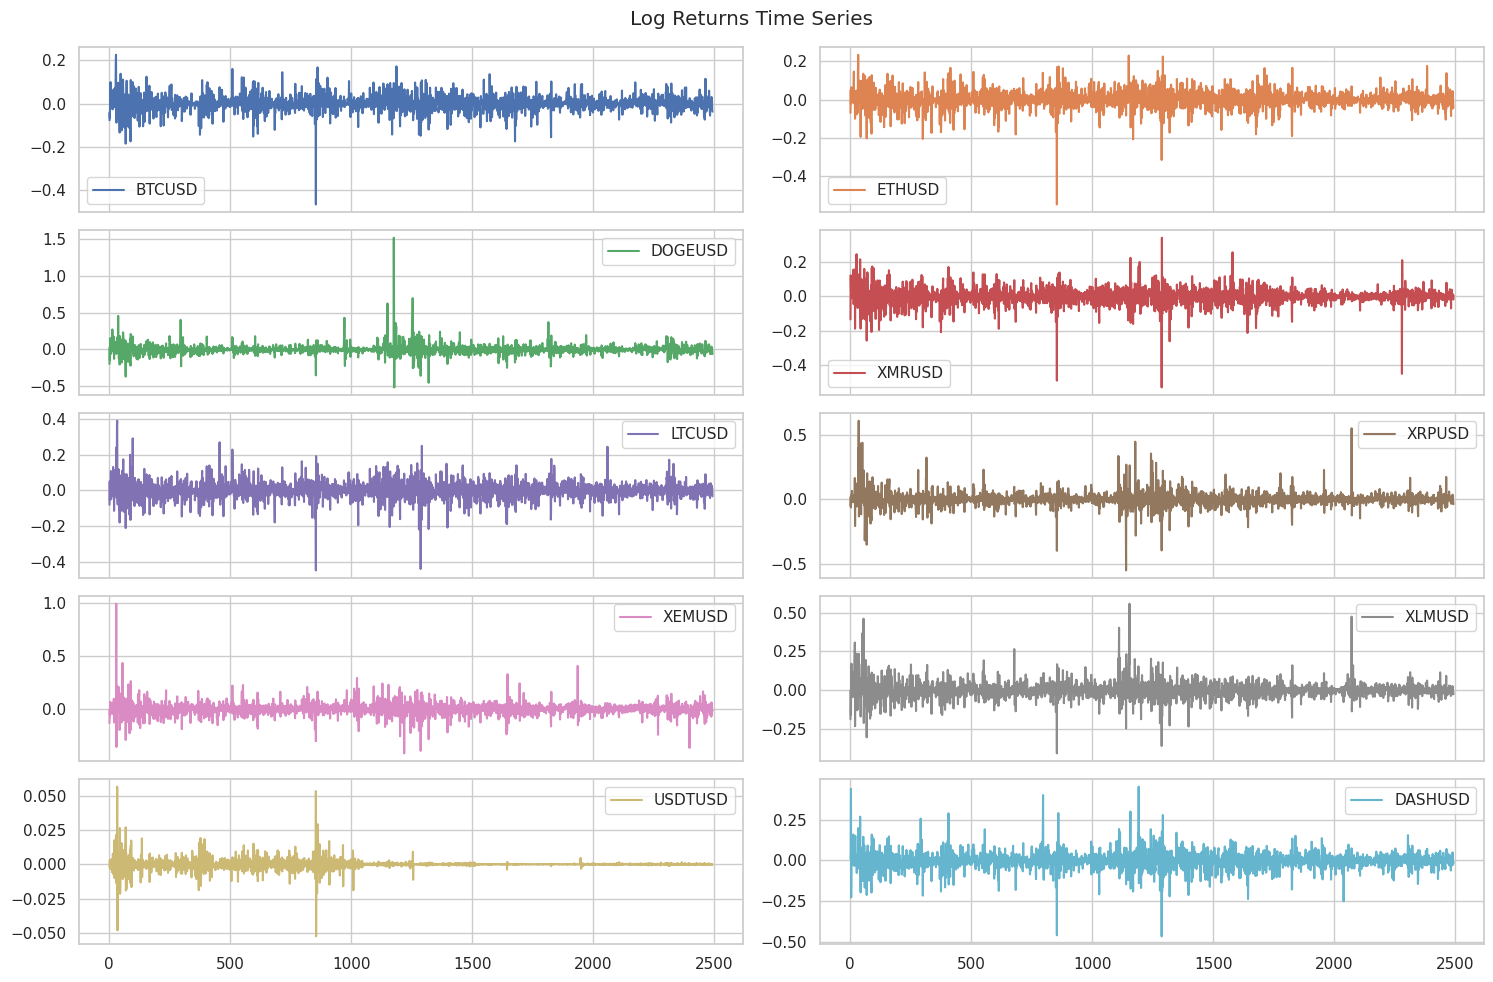

In [87]:

returns_df.plot(subplots=True, layout=(5, 2), figsize=(15, 10), title='Log Returns Time Series')
plt.tight_layout()
plt.show()


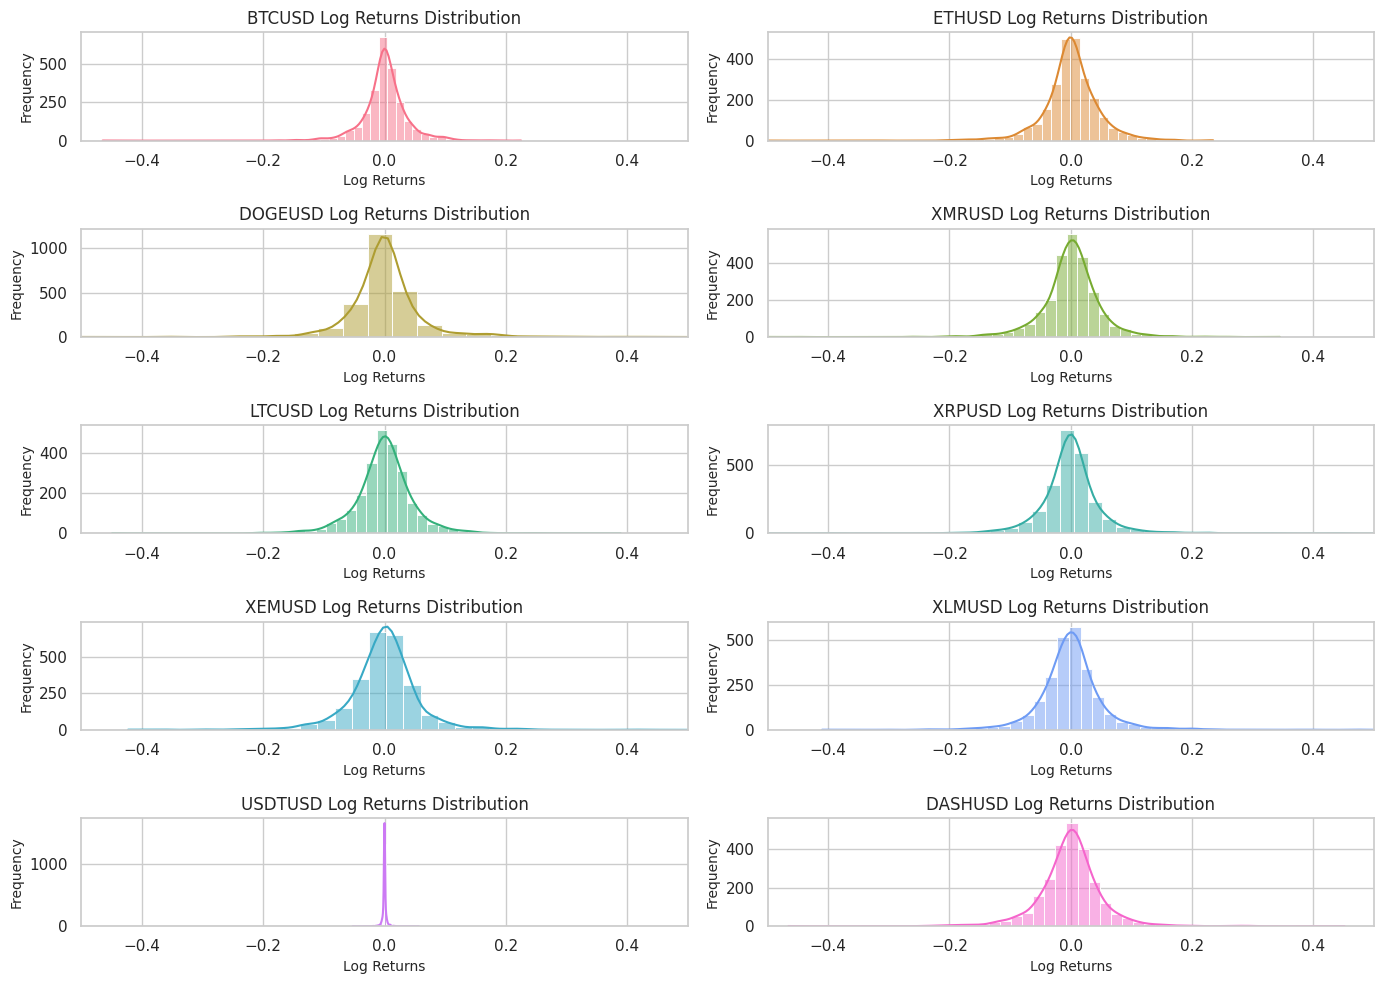

In [88]:



sns.set(style="whitegrid")


fig, axes = plt.subplots(5, 2, figsize=(14, 10))
axes = axes.flatten()

colors = sns.color_palette("husl", len(returns_df.columns))

for i, col in enumerate(returns_df.columns):
    sns.histplot(returns_df[col], kde=True, ax=axes[i], color=colors[i], bins=50)
    axes[i].set_title(f'{col} Log Returns Distribution', fontsize=12)
    axes[i].set_xlabel('Log Returns', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].grid(True)
    axes[i].set_xlim(-0.5, 0.5)

plt.tight_layout()
plt.show()


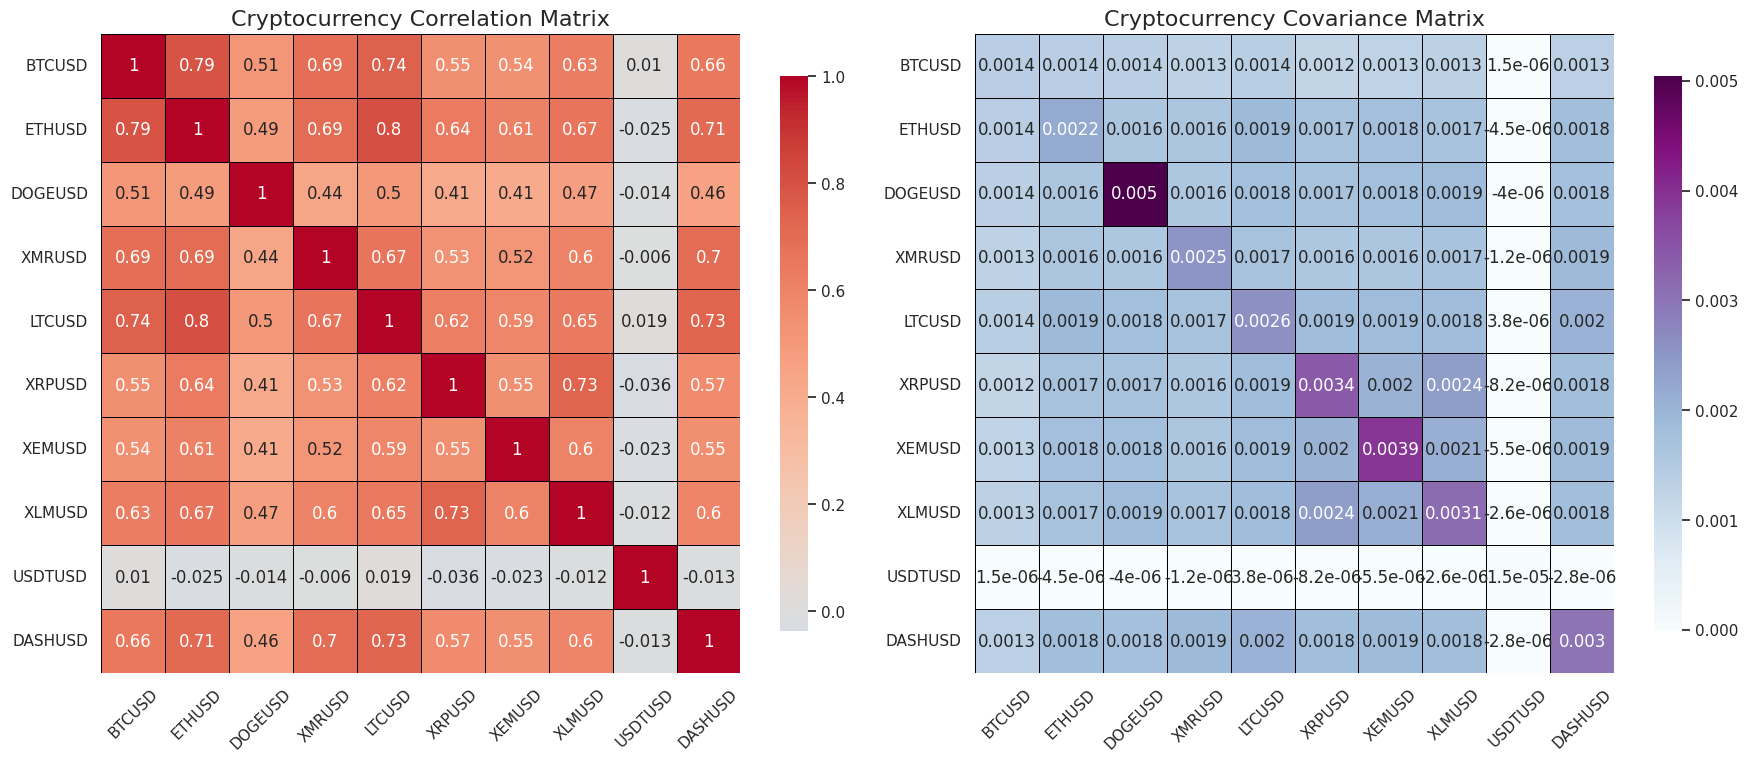

In [89]:

# Calculate correlation and covariance matrices
corr_matrix = returns_df.corr()
cov_matrix = returns_df.cov()


fig, axes = plt.subplots(1, 2, figsize=(18, 8))


sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0],
            linewidths=0.5, linecolor='black', square=True, cbar_kws={"shrink": 0.75})
axes[0].set_title('Cryptocurrency Correlation Matrix', fontsize=16)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

sns.heatmap(cov_matrix, annot=True, cmap='BuPu', ax=axes[1],
            linewidths=0.5, linecolor='black', square=True, cbar_kws={"shrink": 0.75})
axes[1].set_title('Cryptocurrency Covariance Matrix', fontsize=16)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)


plt.tight_layout()
plt.show()


In [94]:

returns_df.columns = [col for col in returns_df.columns]

descriptive_stats = pd.DataFrame(columns=returns_df.columns, index=[
    'sample count', 'min', 'max', 'std', 'mean', 'skewness', 'kurtosis',
    'VaR_95', 'ES_95', 'Sortino_ratio', 'Sharpe_ratio', 'Max_drawdown',
    'ADF', 'Shapiro'
])

descriptive_stats.loc['sample count'] = returns_df.count()
descriptive_stats.loc['min'] = returns_df.min()
descriptive_stats.loc['max'] = returns_df.max()
descriptive_stats.loc['std'] = returns_df.std()
descriptive_stats.loc['mean'] = returns_df.mean()
descriptive_stats.loc['skewness'] = returns_df.apply(skew)
descriptive_stats.loc['kurtosis'] = returns_df.apply(kurtosis)

for pair in returns_df.columns:
    mean_return = descriptive_stats.loc['mean', pair]
    std_dev = descriptive_stats.loc['std', pair]

    # Value at Risk (VaR) at 95% confidence level
    VaR_95 = norm.ppf(0.05, mean_return, std_dev)
    descriptive_stats.loc['VaR_95', pair] = VaR_95

    # Expected Shortfall (ES) at 95% confidence level
    ES_95 = mean_return - (std_dev * norm.pdf(norm.ppf(0.05)) / 0.05)
    descriptive_stats.loc['ES_95', pair] = ES_95

    # Sortino Ratio
    risk_free_rate = 0  # Assuming risk-free rate of return is 0
    downside_returns = returns_df[pair][returns_df[pair] < risk_free_rate]
    downside_deviation = np.sqrt((downside_returns ** 2).mean())
    sortino_ratio = (mean_return - risk_free_rate) / downside_deviation
    descriptive_stats.loc['Sortino_ratio', pair] = sortino_ratio

    # Sharpe Ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev
    descriptive_stats.loc['Sharpe_ratio', pair] = sharpe_ratio

    # Max Drawdown
    cumulative_returns = (1 + returns_df[pair]).cumprod()
    peak_value = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak_value) / peak_value
    max_drawdown = drawdown.min()
    descriptive_stats.loc['Max_drawdown', pair] = max_drawdown

    # Augmented Dickey-Fuller (ADF) Test
    adf_result = adfuller(returns_df[pair], autolag='AIC')
    descriptive_stats.loc['ADF', pair] = adf_result[0]

    # Shapiro-Wilk Test
    shapiro_result = shapiro(returns_df[pair])
    descriptive_stats.loc['Shapiro', pair] = shapiro_result[0]


descriptive_stats

,BTCUSD,ETHUSD,DOGEUSD,XMRUSD,LTCUSD,XRPUSD,XEMUSD,XLMUSD,USDTUSD,DASHUSD
sample count,2493,2493,2493,2493,2493,2493,2493,2493,2493,2493
min,-0.46473,-0.550732,-0.515118,-0.534196,-0.449062,-0.550503,-0.422713,-0.40995,-0.05257,-0.465459
max,0.225119,0.234741,1.516328,0.344954,0.389321,0.606885,0.995577,0.559184,0.056606,0.451304
std,0.037205,0.046821,0.071012,0.050214,0.051054,0.058515,0.062543,0.056006,0.003894,0.054959
mean,0.000812,0.000785,0.001676,0.000136,-0.000003,0.000352,-0.001053,0.000316,-0.000004,-0.001055
skewness,-0.765986,-0.880871,4.820942,-1.190029,-0.099776,1.146264,1.453523,1.041407,0.817683,0.125306
kurtosis,12.841515,10.9797,94.298075,14.734218,9.515268,20.756282,31.6721,13.996936,61.35288,11.20026
VaR_95,-0.060384,-0.076229,-0.115127,-0.082459,-0.083978,-0.095896,-0.103927,-0.091806,-0.006408,-0.091454
ES_95,-0.075931,-0.095794,-0.1448,-0.103441,-0.105312,-0.120347,-0.130061,-0.115208,-0.008035,-0.114419
Sortino_ratio,0.021246,0.016075,0.029318,0.002467,-0.000051,0.00656,-0.017025,0.006073,-0.000937,-0.01878


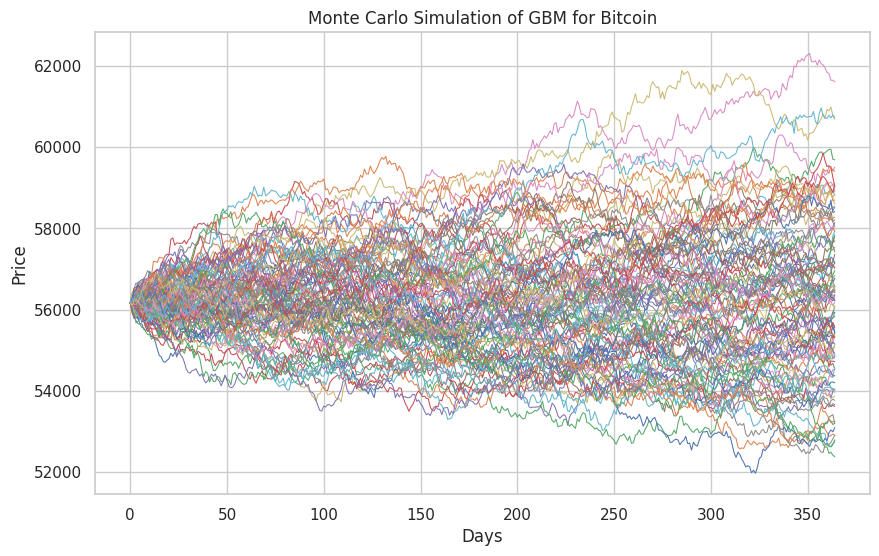

In [91]:

mu = returns_df['BTCUSD'].mean() #mean return
sigma = returns_df['BTCUSD'].std() #volatility


S0 = 56162            # Initial Bitcoin price
T = 1                 # Total time (1 year)
steps = 365          # Number of time steps (daily data)
deltaT = T / steps    # Time step size
Npaths = 1000         # Number of simulated paths
np.random.seed(1)     # Seed for reproducibility


prices = np.zeros((steps, Npaths))
prices[0, :] = S0

for t in range(1, steps):
    shock = np.random.normal(loc=mu * deltaT, scale=sigma * np.sqrt(deltaT), size=Npaths)
    drift = mu * deltaT
    prices[t, :] = prices[t-1, :] + (prices[t-1, :] * (drift + shock))


plt.figure(figsize=(10, 6))
for i in range(100):
    plt.plot(prices[:, i], lw=0.75)
plt.title('Monte Carlo Simulation of GBM for Bitcoin')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()



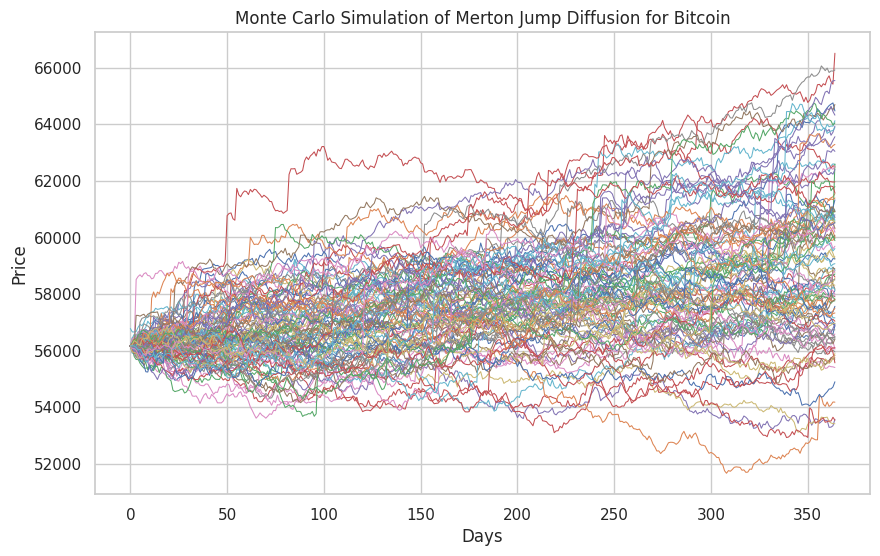

In [92]:


def merton_jump_paths(S, T, sigma, lam, m, v, steps, Npaths, mu):
    deltaT = T / steps
    size = (steps, Npaths)

    price = np.zeros(size)
    shock = np.zeros(size)
    drift = np.zeros(size)

    price[0, :] = S

    for t in range(1, steps):
        shock[t, :] = np.random.normal(loc=mu * deltaT, scale=sigma * np.sqrt(deltaT), size=Npaths)
        drift[t, :] = mu * deltaT
        price[t, :] = price[t-1, :] + (price[t-1, :] * (drift[t, :] + shock[t, :]))


    poi_rv = np.multiply(np.random.poisson(lam * deltaT, size=size),
                         np.random.normal(m, v, size=size)).cumsum(axis=0)

    return price * np.exp(poi_rv)

lam = 2
m = 0.02
v = 0.008

jump_diffusion_paths = merton_jump_paths(S0, T, sigma, lam, m, v, steps, Npaths, mu)

plt.figure(figsize=(10, 6))
for i in range(100):
    plt.plot(jump_diffusion_paths[:, i], lw=0.75)
plt.title('Monte Carlo Simulation of Merton Jump Diffusion for Bitcoin')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()




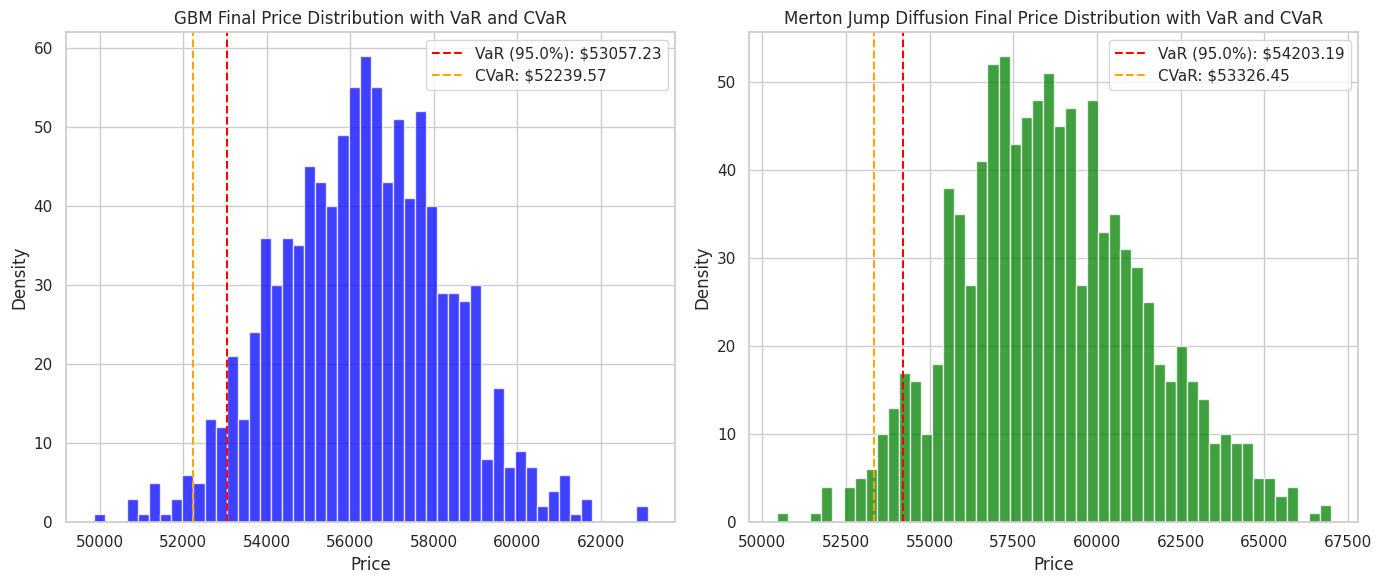

In [93]:

# Risk parameters
confidence_level = 0.95

def calculate_var_cvar(prices, confidence_level=0.95):
    sorted_prices = np.sort(prices)
    var_index = int((1 - confidence_level) * len(sorted_prices))
    var = sorted_prices[var_index]
    cvar = sorted_prices[:var_index].mean()
    return var, cvar

gbm_final_prices = prices[-1, :]
merton_final_prices = jump_diffusion_paths[-1, :]

gbm_var, gbm_cvar = calculate_var_cvar(gbm_final_prices, confidence_level)

merton_var, merton_cvar = calculate_var_cvar(merton_final_prices, confidence_level)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(gbm_final_prices, bins=50, alpha=0.75, color='blue')
plt.axvline(gbm_var, color='red', linestyle='--', label=f'VaR ({confidence_level*100}%): ${gbm_var:.2f}')
plt.axvline(gbm_cvar, color='orange', linestyle='--', label=f'CVaR: ${gbm_cvar:.2f}')
plt.title('GBM Final Price Distribution with VaR and CVaR')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(merton_final_prices, bins=50, alpha=0.75, color='green')
plt.axvline(merton_var, color='red', linestyle='--', label=f'VaR ({confidence_level*100}%): ${merton_var:.2f}')
plt.axvline(merton_cvar, color='orange', linestyle='--', label=f'CVaR: ${merton_cvar:.2f}')
plt.title('Merton Jump Diffusion Final Price Distribution with VaR and CVaR')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()
